#### **1. Orientation & Goals**

**🧭 What we’re doing today**
In NB01–NB03 we learned to turn a univariate series into sliding windows, trained sequence models, and compared **Recursive** vs **Direct** forecasting.  
In **NB04** we shift into an **architecture lab**: we compare **capacity choices** for sequence forecasting on the same task.

We will vary:
- **Input window length $S$** (e.g., $7 \rightarrow 14 \rightarrow 30$): how many past days we feed in.
- **Depth** (1 vs 2 recurrent layers) and **dropout** (e.g., $0.0$ vs $0.2$).
- **Cell type:** **LSTM** vs **GRU** (both with gating, different parameterization).

Our question: **Which combination gives the best generalization under our constraints?**


**⚖️ What “better” means (our success criteria)**
We’ll call a configuration “better” if it achieves, on **validation** and then **test**:

- **Lower error in °C**:
  $$
  \text{MAE} = \frac{1}{N}\sum_{i=1}^{N}\lvert y_i - \hat y_i\rvert,
  \qquad
  \text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat y_i)^2}.
  $$
  (We also look at per-horizon metrics $\text{MAE}@k$, $\text{RMSE}@k$ when we roll out.)
- **Flatter error vs horizon** for short multi-step rollouts (less **compounding** as $k$ grows).
- **Healthier training curves**: train and val loss both go down without widening gaps (less overfitting).
- **Reasonable runtime** on CPU (we keep epochs modest and models compact).

When two configs are statistically similar, we break ties by **stability** (flatter MAE@k) and **simplicity** (fewer params).

**⏱️ Constraints (so we don’t melt CPUs)**
- **CPU-only** execution.
- **Short runs** (about 15–20 epochs per config).
- **Modest hidden sizes** (e.g., $64$) and batch-first tensors to match our previous notebooks.
- **Small, focused grids** (we avoid combinatorial explosions).

**🔁 What we reuse from NB03**
- The **data framing idea** (sliding windows), and the norm: **fit scaler on train only**, transform val/test (no leakage).
- **Batch-first tensors** with shape $(B, S, 1)$.
- The evaluation habit: train in **scaled space**, report metrics in **°C** after **inverse transform**.

**💾 What we will save**
We keep artifacts light:
- Save **only** the **best model’s** `state_dict` and a tiny config (cell type, $S$, layers, dropout, hidden size).
- In the next notebook we will **rebuild** the pipeline and load this one checkpoint.

**🧪 Roadmap for NB04 (high level)**
1. **Reload data** (strict dates) → **time split** → **scale** (fit on train) → make windows/loaders for chosen $S$ values.  
2. **Experiment A:** vary **$S \in \{7, 14, 30\}$** with a fixed cell (e.g., GRU) to see sequence-length sensitivity.  
3. **Experiment B:** small grid over **cell type × depth × dropout** at the best $S$.  
4. **Tiny gradient-flow peek** for the top LSTM vs GRU to sanity-check stability.  
5. **Generalization check** on the test set (+ optional short-horizon rollout).  
6. **Select & save** the winner + key takeaways.


**💬 Reflection — Why might a longer $S$ help or hurt?**
**Helps:**  
- More **context** about seasonal lead-ups (e.g., warming/cooling trends) reduces **phase lag** in turning points.  
- Gated cells can carry **longer-term cues** when $S$ extends beyond a week.

**Hurts:**  
- Longer sequences can be **harder to optimize** (noisy gradients, more steps to learn alignment).  
- With small data, a large $S$ increases the chance of **overfitting** (the model memorizes local wiggles).  
- Runtime grows with $S$ (more timesteps per batch).

As we test $S=7,14,30$, we’ll watch for the trade-off: **does added context reduce error without overfitting or slowing learning too much?**

---


### **2. Data Reload, Time Split, Scaling, and Windows (self-contained)**

In this section we **rebuild the full data pipeline from scratch** so NB04 stands on its own:

- Reload the CSV with **strict** date parsing and set `Date` as the index.
- Make a **time-aware** split:  
  **Train:** 1981–1987, **Val:** 1988 (used to pick architectures), **Test:** 1989–1990.
- Fit **MinMaxScaler** on **train only** (to avoid leakage), then transform val/test.
- Build **single-step** windows for fast architecture comparisons (we’ll still be able to do short recursive rollouts later).
- Keep tensors **batch-first**: $(B, S, 1)$.

We will also handle tiny issues safely: detect the **date format** (mm/dd/yy vs dd/mm/yy), **impute** any sporadic missing temps by **linear interpolation**, and verify that our splits are clean.

**🔍 Why single-step now?
For NB04, we want to compare **capacity choices** (cell type, depth, dropout, $S$). Training on **$H=1$** keeps runs **CPU-friendly** and focuses the comparison. We can still **roll out** a few steps at the end to see how error grows with horizon.

**⚠️ No leakage rule**
We’ll fit the scaler **only on the train slice**. Conceptually, MinMax scaling does:
$$
y_{\text{scaled}} = \frac{y - y_{\min}^{\text{train}}}{y_{\max}^{\text{train}} - y_{\min}^{\text{train}}}.
$$
If we used val/test to compute $y_{\min},y_{\max}$, we would be **peeking** at the future, causing optimistic errors.


**What we’ll do next in code:**
We import libraries, load the CSV without parsing dates first, then detect which date format fits best (try "%m/%d/%y" then "%d/%m/%y"). We set the parsed Date as a monotonic index and keep only the Temp column as float.

In [ ]:
# --- Code: Load CSV, strict date parsing, set Date index ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "dataset/1_Daily_minimum_temps.csv"

# Load as strings first
df_raw = pd.read_csv(CSV_PATH, dtype={"Date": str})
assert "Date" in df_raw.columns and "Temp" in df_raw.columns, "Expected columns: Date, Temp"

def try_parse_date(series, fmt):
    dt = pd.to_datetime(series, format=fmt, errors="coerce")
    return dt, dt.notna().sum()

# Try mm/dd/yy first, then dd/mm/yy; pick the one with fewer NaT
d1, ok1 = try_parse_date(df_raw["Date"], "%m/%d/%y")
d2, ok2 = try_parse_date(df_raw["Date"], "%d/%m/%y")

if ok1 >= ok2:
    df_raw["Date"] = d1
    chosen_fmt = "%m/%d/%y"
else:
    df_raw["Date"] = d2
    chosen_fmt = "%d/%m/%y"

print(f"Chosen date format: {chosen_fmt}  | parsed ok: {max(ok1, ok2)} / {len(df_raw)}")

# Drop unparsed rows (if any), cast Temp to float
df = df_raw.dropna(subset=["Date"]).copy()
df["Temp"] = pd.to_numeric(df["Temp"], errors="coerce")

# Set index, sort, keep only the signal
df = df.set_index("Date").sort_index()[["Temp"]]

# Basic sanity
assert df.index.is_monotonic_increasing, "Date index must be sorted ascending"
print("Shape:", df.shape)
print(df.head(3))
print(df.tail(3))


Chosen date format: %m/%d/%y  | parsed ok: 3650 / 3650
Shape: (3650, 1)
            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
            Temp
Date            
1990-12-29  13.5
1990-12-30  15.7
1990-12-31  13.0


**Code:**
We clean the series: check for missing/inf values and impute any tiny gaps via linear interpolation (bidirectional) so we don’t create artifacts when we build windows.

In [ ]:
# --- Code: Clean/impute tiny gaps safely ---
# Replace inf with NaN, then linear interpolation; fill edges if needed
s = df["Temp"].replace([np.inf, -np.inf], np.nan)
nan_before = s.isna().sum()

s = s.interpolate(method="linear", limit_direction="both")
nan_after = s.isna().sum()

df["Temp"] = s
print(f"Missing values before: {nan_before} | after interpolation: {nan_after}")


Missing values before: 3 | after interpolation: 0


**Code:**
We create time-aware splits that mirror our earlier notebooks but carve out 1988 as validation (to select architectures):

- **Train:** 1981-01-01 … 1987-12-31
- **Val:** 1988-01-01 … 1988-12-31
- **Test:** 1989-01-01 … 1990-12-31

We’ll print the date ranges for each split.

In [ ]:
# --- Code: Time-aware split: Train (81-87), Val (88), Test (89-90) ---
train = df.loc["1981-01-01":"1987-12-31"].copy()
val   = df.loc["1988-01-01":"1988-12-31"].copy()
test  = df.loc["1989-01-01":"1990-12-31"].copy()

def span(x):
    return f"{x.index.min().date()} → {x.index.max().date()} ({len(x)} days)"

print("Train span:", span(train))
print("Val   span:", span(val))
print("Test  span:", span(test))


Train span: 1981-01-01 → 1987-12-31 (2555 days)
Val   span: 1988-01-01 → 1988-12-30 (365 days)
Test  span: 1989-01-01 → 1990-12-31 (730 days)


**Code:** 
We scale with **MinMaxScaler** fitted on **train only**, then transform val/test.  
We’ll print scaled min/max for each split (the train split will map roughly to $[0,1]$, val/test may be slightly outside if they contain temps unseen in train — which is fine).

We will also define a **window builder** for single-step targets:

- Given a series of shape $(N, 1)$ and a window size $S$, it returns:  

$$
X \in \mathbb{R}^{(N-S)\times S \times 1}, \quad 
y \in \mathbb{R}^{(N-S)\times 1}
$$

where  

$$
X_i = [T_i, \dots, T_{i+S-1}], \quad y_i = T_{i+S}.
$$

We build **per split** to ensure no window crosses the split boundary.


In [ ]:
# --- Code: Scale (fit on train only) and build single-step windows (per split) ---
from sklearn.preprocessing import MinMaxScaler

# Numpy arrays (N,1)
train_np = train[["Temp"]].to_numpy(dtype=float)
val_np   = val[["Temp"]].to_numpy(dtype=float)
test_np  = test[["Temp"]].to_numpy(dtype=float)

scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train_np)
val_sc   = scaler.transform(val_np)
test_sc  = scaler.transform(test_np)

print("Scaled ranges:")
print("  Train:", float(train_sc.min()), "→", float(train_sc.max()))
print("  Val  :", float(val_sc.min()),   "→", float(val_sc.max()))
print("  Test :", float(test_sc.min()),  "→", float(test_sc.max()))

def make_single_step_windows(values: np.ndarray, S: int):
    """
    values: (N,1) scaled series
    returns: X: (N-S, S, 1), y: (N-S, 1)
    """
    N = len(values)
    X = np.stack([values[i:i+S, :] for i in range(N - S)], axis=0)
    y = values[S:, :]  # next value after each window
    return X, y

# Default S for capacity tests; we’ll vary S later in Experiment A
S = 7

X_train_sc, y_train_sc = make_single_step_windows(train_sc, S)
X_val_sc,   y_val_sc   = make_single_step_windows(val_sc,   S)
X_test_sc,  y_test_sc  = make_single_step_windows(test_sc,  S)

print(f"Shapes @ S={S}:")
print("  X_train:", X_train_sc.shape, "| y_train:", y_train_sc.shape)
print("  X_val  :", X_val_sc.shape,   "| y_val  :", y_val_sc.shape)
print("  X_test :", X_test_sc.shape,  "| y_test :", y_test_sc.shape)


Scaled ranges:
  Train: 0.0 → 1.0
  Val  : 0.10646387832699619 → 0.9087452471482889
  Test : 0.019011406844106463 → 0.8403041825095058
Shapes @ S=7:
  X_train: (2548, 7, 1) | y_train: (2548, 1)
  X_val  : (358, 7, 1) | y_val  : (358, 1)
  X_test : (723, 7, 1) | y_test : (723, 1)


**Code:** We build PyTorch TensorDatasets and DataLoaders with batch-first tensors $(B,S,1)$. We also draw a tiny sanity plot of 3 sample windows from the validation split to visualize what the model sees.

Batch X shape: (64, 7, 1) | Batch y shape: (64, 1)


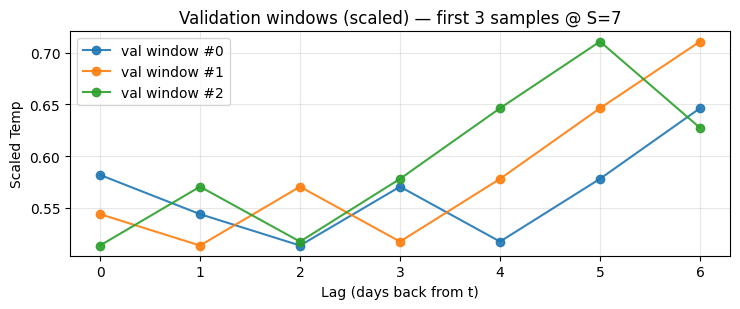

In [ ]:
# --- Code: DataLoaders (batch-first) + quick sanity plot of a few windows ---
import torch
from torch.utils.data import TensorDataset, DataLoader

BATCH = 64

train_ds = TensorDataset(
    torch.tensor(X_train_sc, dtype=torch.float32),
    torch.tensor(y_train_sc, dtype=torch.float32),
)
val_ds = TensorDataset(
    torch.tensor(X_val_sc, dtype=torch.float32),
    torch.tensor(y_val_sc, dtype=torch.float32),
)
test_ds = TensorDataset(
    torch.tensor(X_test_sc, dtype=torch.float32),
    torch.tensor(y_test_sc, dtype=torch.float32),
)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

# Batch-first confirmation
xb, yb = next(iter(train_loader))
print("Batch X shape:", tuple(xb.shape), "| Batch y shape:", tuple(yb.shape))  # expect (B, S, 1), (B, 1)

# Quick sanity plot: 3 validation windows (scaled)
plt.figure(figsize=(7.5, 3.2))
for i in range(3):
    w = X_val_sc[i, :, 0]  # length S
    plt.plot(range(S), w, marker="o", alpha=0.9, label=f"val window #{i}")
plt.title(f"Validation windows (scaled) — first {3} samples @ S={S}")
plt.xlabel("Lag (days back from t)")
plt.ylabel("Scaled Temp")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**🧠 Reflection — Why drop windows that cross the split boundary?**

Our splits simulate **real forecasting**: we learn on the **past** and evaluate on the **future**.  
If we built windows over the **entire series** and then split, some windows near the boundary would **include future values** inside the input for training (or earlier values inside test), which is **data leakage**.

By creating windows **per split**:
- **Train windows** only use 1981–1987 data to predict **next-day within train**.
- **Val windows** only use 1988 data to pick architectures.
- **Test windows** are formed only from 1989–1990.

This way, our evaluation reflects the **real task**: use the **past context** to predict the **next day** without peeking across the boundary.

---


#### **3. Experiment A — Sequence Length Sensitivity ($S\in\{7,14,30\}$)**

**Teach (markdown):**

* Hypothesis: larger $S$ may encode **seasonal lead-ups** and reduce **phase lag**, but can also **raise variance** and slow learning.
* Keep **one cell type fixed** (e.g., **GRU**, 1 layer, hidden=64), vary **only $S$**.

**Code (tasks):**

* Loop over $S\in\{7,14,30\}$: rebuild windows/loaders; train **short** (e.g., 15–20 epochs).
* Track **train/val MSE** in scaled space, then compute **val MAE/RMSE** in °C.

**Outputs:**

* Table: $S$ vs val/test MAE & RMSE in °C.
* Plot: **val-loss vs epoch** per $S$ (overlay).

**Reflection:** Does larger $S$ flatten error at $k=1$? Any sign of **overfitting** (train ↓ while val ↔/↑)?


**Code:** 
Define the GRU single-step model and set seeds so runs are repeatable. The model reads $(B,S,1)$ and outputs $(B,1)$ in scaled space.

In [ ]:
# --- Code: Model (GRU single-step) + seeds ---
import torch
import torch.nn as nn
import random

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

class GRUSingleStep(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, 1)  # linear head for regression in scaled space

    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros(self.gru.num_layers, B, self.gru.hidden_size)
        out, _ = self.gru(x, h0)         # (B,S,H)
        h_last = out[:, -1, :]           # (B,H)
        y_hat  = self.head(h_last)       # (B,1) scaled
        return y_hat


**Code:**
Write small helpers:
- training loop (scaled MSE, optional grad clipping),
- evaluator (scaled MSE),
- batched prediction,
- inverse scaling back to °C,
- and metric functions MAE/RMSE.

In [ ]:
# --- Code : Training/eval helpers (scaled) + inverse scale + metrics ---
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cpu")
EPOCHS = 18
LR     = 1e-3
CLIP   = 1.0
BATCH  = 64

criterion = nn.MSELoss()

def train_one_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, clip=CLIP):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    tr_hist, va_hist = [], []
    for ep in range(1, epochs+1):
        # Train
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
        # Eval (scaled MSE)
        tr_mse = eval_mse_scaled(model, train_loader)
        va_mse = eval_mse_scaled(model, val_loader)
        tr_hist.append(tr_mse); va_hist.append(va_mse)
        if ep in (1, 6, 12, epochs):
            print(f"[S={S_current}, ep {ep:02d}] train MSE={tr_mse:.5f} | val MSE={va_mse:.5f}")
    return tr_hist, va_hist

@torch.no_grad()
def eval_mse_scaled(model, loader):
    model.eval()
    tot, n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        yhat = model(xb)
        loss = criterion(yhat, yb)
        bs = xb.size(0)
        tot += loss.item() * bs
        n   += bs
    return tot / max(n, 1)

@torch.no_grad()
def predict_scaled(model, X_sc, batch=BATCH):
    model.eval()
    preds = []
    for i in range(0, len(X_sc), batch):
        xb = torch.tensor(X_sc[i:i+batch], dtype=torch.float32).to(DEVICE)
        yhat = model(xb).cpu().numpy()
        preds.append(yhat)
    return np.vstack(preds)  # (N,1) scaled

def inverse_scale_1d(y_scaled):
    flat = y_scaled.reshape(-1, 1)
    back = scaler.inverse_transform(flat)
    return back.ravel()

def mae(a, b):  return float(np.mean(np.abs(a - b)))
def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))


**Code:**
Create a runner that, for each $S\in{7,14,30}$:

1. Rebuild single-step windows for train/val/test (scaled).
2. Also build $y$ in °C for val/test for reporting.
3. Build DataLoaders, train the GRU briefly, record curves.
4. Predict on val/test, inverse-scale to °C, compute MAE/RMSE.<br>
We’ll collect curves and a metrics table.

In [ ]:
# --- Code: Loop over S in {7,14,30} and run training + metrics ---
results = []
curves  = {}  # S -> (train_curve, val_curve)

S_values = [7, 14, 30]

for S_current in S_values:
    # Rebuild windows (scaled)
    X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, S_current)
    X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   S_current)
    X_test_sc_S,  y_test_sc_S  = make_single_step_windows(test_sc,  S_current)

    # Build targets in °C to evaluate later
    _, y_val_C_S  = make_single_step_windows(val_np,  S_current)   # (N,1) in °C
    _, y_test_C_S = make_single_step_windows(test_np, S_current)

    # DataLoaders
    train_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                      torch.tensor(y_train_sc_S, dtype=torch.float32)),
        batch_size=BATCH, shuffle=True, drop_last=False)
    val_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                      torch.tensor(y_val_sc_S, dtype=torch.float32)),
        batch_size=BATCH, shuffle=False, drop_last=False)
    test_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_test_sc_S, dtype=torch.float32),
                      torch.tensor(y_test_sc_S, dtype=torch.float32)),
        batch_size=BATCH, shuffle=False, drop_last=False)

    # Model
    model = GRUSingleStep(input_size=1, hidden_size=64, num_layers=1, batch_first=True, dropout=0.0)

    # Train briefly
    tr_curve, va_curve = train_one_model(model, train_loader_S, val_loader_S, epochs=EPOCHS, lr=LR, clip=CLIP)
    curves[S_current] = (tr_curve, va_curve)

    # Predict and report in °C (single-step)
    y_val_hat_sc  = predict_scaled(model, X_val_sc_S)[:, 0]   # (N,)
    y_test_hat_sc = predict_scaled(model, X_test_sc_S)[:, 0]
    y_val_hat_C   = inverse_scale_1d(y_val_hat_sc)
    y_test_hat_C  = inverse_scale_1d(y_test_hat_sc)

    # Flatten ground-truth (°C)
    y_val_true_C  = y_val_C_S.ravel()
    y_test_true_C = y_test_C_S.ravel()

    row = {
        "S": S_current,
        "Val_MAE_C":  mae(y_val_true_C,  y_val_hat_C),
        "Val_RMSE_C": rmse(y_val_true_C, y_val_hat_C),
        "Test_MAE_C":  mae(y_test_true_C,  y_test_hat_C),
        "Test_RMSE_C": rmse(y_test_true_C, y_test_hat_C),
    }
    results.append(row)

df_S = pd.DataFrame(results).set_index("S").sort_values("Val_RMSE_C")
display(df_S.round(3))


[S=7, ep 01] train MSE=0.02173 | val MSE=0.02083
[S=7, ep 06] train MSE=0.01103 | val MSE=0.01014
[S=7, ep 12] train MSE=0.00992 | val MSE=0.00943
[S=7, ep 18] train MSE=0.00927 | val MSE=0.00885
[S=14, ep 01] train MSE=0.01855 | val MSE=0.01716
[S=14, ep 06] train MSE=0.01034 | val MSE=0.00956
[S=14, ep 12] train MSE=0.00964 | val MSE=0.00902
[S=14, ep 18] train MSE=0.00955 | val MSE=0.00905
[S=30, ep 01] train MSE=0.01770 | val MSE=0.01528
[S=30, ep 06] train MSE=0.00965 | val MSE=0.00894
[S=30, ep 12] train MSE=0.00957 | val MSE=0.00913
[S=30, ep 18] train MSE=0.00889 | val MSE=0.00862


,Val_MAE_C,Val_RMSE_C,Test_MAE_C,Test_RMSE_C
S,,,,
30,1.894,2.441,1.753,2.241
7,1.946,2.474,1.779,2.278
14,1.938,2.503,1.830,2.319


**Code:**
Overlay the validation MSE curves (scaled) across $S$ to visualize learning speed and stability.

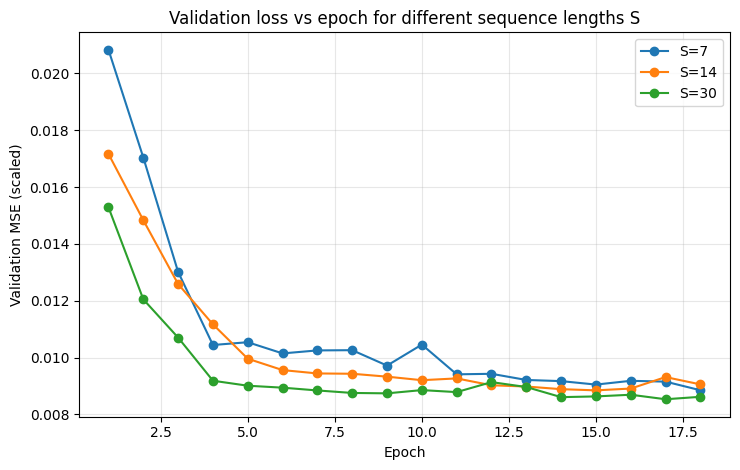

In [ ]:
# --- Code: Plot val-loss (scaled MSE) vs epoch for each S (overlay) ---
plt.figure(figsize=(7.5, 4.8))
for S_current in S_values:
    tr, va = curves[S_current]
    plt.plot(range(1, len(va)+1), va, marker="o", label=f"S={S_current}")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE (scaled)")
plt.title("Validation loss vs epoch for different sequence lengths S")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**Code:**
Optionally, show a tiny one-step sanity slice in °C on the validation set for the best S to get a feel for phase tracking.

Best S by Val_RMSE_C: 30
[S=30, ep 01] train MSE=0.01662 | val MSE=0.01481
[S=30, ep 06] train MSE=0.00981 | val MSE=0.00919
[S=30, ep 08] train MSE=0.00927 | val MSE=0.00872


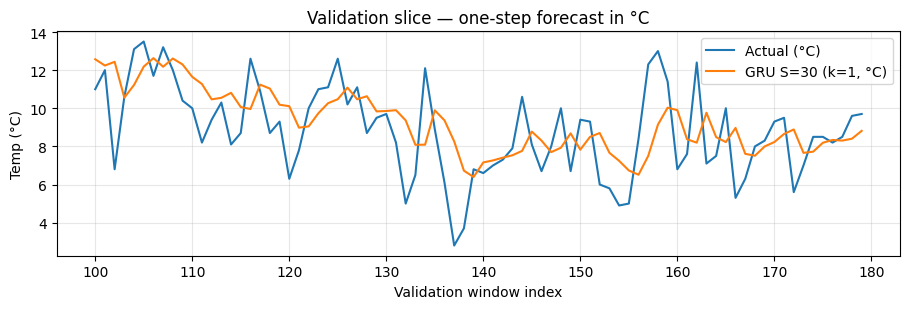

In [ ]:
# --- Code (optional): Quick slice plot (val, k=1) for best S ---
best_S = df_S.index[0]
print(f"Best S by Val_RMSE_C: {best_S}")

# Rebuild to get predictions for the chosen S (in case variables were overwritten)
X_val_sc_S, _ = make_single_step_windows(val_sc, best_S)
_, y_val_C_S  = make_single_step_windows(val_np, best_S)

# Refit a fresh model quickly for the slice (or reuse the trained one if kept)
model_bestS = GRUSingleStep(input_size=1, hidden_size=64, num_layers=1, batch_first=True, dropout=0.0)
# A quick re-train for 8 epochs to ensure the object is live (keeps CPU light)
_ , _ = train_one_model(model_bestS,
                        DataLoader(TensorDataset(torch.tensor(make_single_step_windows(train_sc, best_S)[0], dtype=torch.float32),
                                                 torch.tensor(make_single_step_windows(train_sc, best_S)[1], dtype=torch.float32)),
                                   batch_size=BATCH, shuffle=True),
                        DataLoader(TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                                                 torch.tensor(make_single_step_windows(val_sc, best_S)[1], dtype=torch.float32)),
                                   batch_size=BATCH, shuffle=False),
                        epochs=8)

y_val_hat_sc = predict_scaled(model_bestS, X_val_sc_S)[:, 0]
y_val_hat_C  = inverse_scale_1d(y_val_hat_sc)
y_val_true_C = y_val_C_S.ravel()

idx0, idx1 = 100, 180
x_axis = np.arange(idx0, idx1)
plt.figure(figsize=(9.2, 3.2))
plt.plot(x_axis, y_val_true_C[idx0:idx1], label="Actual (°C)")
plt.plot(x_axis, y_val_hat_C[idx0:idx1],  label=f"GRU S={best_S} (k=1, °C)")
plt.title("Validation slice — one-step forecast in °C")
plt.xlabel("Validation window index")
plt.ylabel("Temp (°C)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**🧠 Interpretation guide**

- **Table (by $S$):**  
  - Look at **Val\_RMSE\_C** first. Does a larger $S$ yield lower error? Or does it stall (noisy learning) compared to $S=7$?  
  - Confirm on **Test\_RMSE\_C** that the choice generalizes.

- **Curves (val MSE):**  
  - If $S=30$ descends **slower** or **plateaus** higher, that suggests the model struggles to exploit the longer context under our compute budget.  
  - If $S=14$ or $S=30$ sits **below** $S=7$ consistently, we’ve gained from extra context.

**💬 Reflection — Does larger $S$ flatten error at $k=1$?**
- **Yes:** likely the model is using **seasonal lead-ups**, reducing **phase lag** and improving turning points.  
- **No / Mixed:** with small data and short training, larger $S$ can **raise variance** and be **harder to optimize**; try a **few more epochs**, a **slightly larger hidden size**, or keep $S$ modest and add **seasonal features** (e.g., day-of-year $\sin/\cos$) in NB05.

> If we see **train MSE** falling while **val MSE** stays flat or rises, that’s a sign of **overfitting** (or insufficient regularization). In Experiment B we’ll test **depth** and **dropout** to address this.

---

#### **4. Experiment B: Depth & Dropout (LSTM vs GRU × 1 vs 2 layers × dropout)**

**🧭 Goal**
Now that we’ve chosen a good sequence length $S$ (from Experiment A), we compare **architectures** under a small, CPU-friendly grid:

- **Cell:** GRU vs LSTM  
- **Depth:** $1$ vs $2$ recurrent layers  
- **Dropout:** $0.0$ vs $0.2$ (applies only when layers $>1$ in PyTorch)  
- **Fixed:** hidden size $=64$, batch-first $(B,S,1)$, single-step target, brief training (≈15–20 epochs)

** Why stack?**
Deeper encoders may capture **hierarchical temporal structure**: a first layer learns short jitter; a second layer summarizes **slower drift**. But adding depth increases parameters and can **overfit** faster.

**💡 Why dropout?**
Dropout reduces **co-adaptation** between hidden units, often improving **generalization**. Too much dropout can **wash out** subtle temporal cues (especially with small data).

We’ll train every config with the **same loop**, track **train/val MSE (scaled)**, and report **MAE/RMSE in °C** on **val** and **test**. We’ll then sort a compact table by **Val mean RMSE** (here, single-step RMSE) and overlay the **val-loss curves** for the top 2–3 configs.


**Code:**
We define parameterized GRU/LSTM models that accept num_layers, dropout, and batch_first=True. We keep a linear head for regression in scaled space. (PyTorch applies recurrent dropout only when num_layers > 1.)

In [ ]:
# --- Code: Parameterized GRU/LSTM classes (single-step, batch-first) ---
import torch
import torch.nn as nn

class GRUSingleStepCfg(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0, batch_first=True):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros(self.gru.num_layers, B, self.gru.hidden_size)
        out, _ = self.gru(x, h0)     # (B,S,H)
        h_last = out[:, -1, :]       # (B,H)
        return self.head(h_last)     # (B,1), scaled space

class LSTMSingleStepCfg(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0, batch_first=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros(self.lstm.num_layers, B, self.lstm.hidden_size)
        c0 = x.new_zeros(self.lstm.num_layers, B, self.lstm.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  # (B,S,H)
        h_last = out[:, -1, :]           # (B,H)
        return self.head(h_last)         # (B,1), scaled space


**Code:**
We set up a runner that, for a given config, trains briefly on Train, monitors Val in scaled MSE, then computes Val/Test MAE & RMSE in °C. We’ll also ensure we’re using the best $S$ from Experiment A (falling back to $S=7$ if not found).

In [ ]:
# --- Code: Config runner (train, curves, metrics in °C) ---
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Use best S from Experiment A (df_S), else default to 7
try:
    BEST_S = int(df_S.index[0])
except Exception:
    BEST_S = 7
print(f"Using S={BEST_S} for Experiment B")

# Rebuild windows for BEST_S
X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, BEST_S)
X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   BEST_S)
X_test_sc_S,  y_test_sc_S  = make_single_step_windows(test_sc,  BEST_S)

# Ground-truth in °C for reporting
_, y_val_C_S  = make_single_step_windows(val_np,  BEST_S)
_, y_test_C_S = make_single_step_windows(test_np, BEST_S)
y_val_true_C  = y_val_C_S.ravel()
y_test_true_C = y_test_C_S.ravel()

# DataLoaders
BATCH = 64
train_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                  torch.tensor(y_train_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=True, drop_last=False)
val_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                  torch.tensor(y_val_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False, drop_last=False)
test_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_test_sc_S, dtype=torch.float32),
                  torch.tensor(y_test_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False, drop_last=False)

DEVICE   = torch.device("cpu")
EPOCHS_B = 18
LR_B     = 1e-3
CLIP_B   = 1.0
criterion = nn.MSELoss()

def train_eval_config(model, label:str, epochs=EPOCHS_B, lr=LR_B, clip=CLIP_B):
    """Train one config; return curves (train/val scaled MSE) and val/test metrics in °C."""
    model = model.to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    tr_hist, va_hist = [], []

    # train
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader_S:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()

        # scaled MSE for curves
        tr_mse = eval_mse_scaled(model, train_loader_S)
        va_mse = eval_mse_scaled(model, val_loader_S)
        tr_hist.append(tr_mse); va_hist.append(va_mse)
        if ep in (1, 6, 12, epochs):
            print(f"[{label} | ep {ep:02d}] train MSE={tr_mse:.5f} | val MSE={va_mse:.5f}")

    # predictions (scaled) -> °C
    @torch.no_grad()
    def predict_loader(loader):
        model.eval()
        out = []
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            out.append(model(xb).cpu().numpy())
        return np.vstack(out).ravel()

    y_val_hat_sc  = predict_loader(val_loader_S)
    y_test_hat_sc = predict_loader(test_loader_S)
    y_val_hat_C   = inverse_scale_1d(y_val_hat_sc)
    y_test_hat_C  = inverse_scale_1d(y_test_hat_sc)

    def mae(a, b):  return float(np.mean(np.abs(a - b)))
    def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))

    metrics = {
        "Val_MAE_C":  mae(y_val_true_C,  y_val_hat_C),
        "Val_RMSE_C": rmse(y_val_true_C, y_val_hat_C),
        "Test_MAE_C":  mae(y_test_true_C,  y_test_hat_C),
        "Test_RMSE_C": rmse(y_test_true_C, y_test_hat_C),
    }
    return tr_hist, va_hist, metrics


Using S=30 for Experiment B


**Code:**
We define the grid, run every config with the same training pipeline, and collect curves and metrics. Then we build a tidy DataFrame sorted by Val_RMSE_C.

In [ ]:
# --- Code: Run the grid and collect results ---
grid = []
for cell in ["GRU", "LSTM"]:
    for layers in [1, 2]:
        for dropout in [0.0, 0.2]:
            # PyTorch ignores dropout if layers == 1; we still list it for completeness
            grid.append((cell, layers, dropout))

curves_B = {}   # label -> (train_curve, val_curve)
rows_B   = []

for (cell, layers, dropout) in grid:
    label = f"{cell}-L{layers}-do{dropout}"
    if cell == "GRU":
        model = GRUSingleStepCfg(input_size=1, hidden_size=64, num_layers=layers, dropout=dropout, batch_first=True)
    else:
        model = LSTMSingleStepCfg(input_size=1, hidden_size=64, num_layers=layers, dropout=dropout, batch_first=True)

    tr_curve, va_curve, m = train_eval_config(model, label=label, epochs=EPOCHS_B, lr=LR_B, clip=CLIP_B)
    curves_B[label] = (tr_curve, va_curve)
    row = {"Cell": cell, "Layers": layers, "Dropout": dropout}
    row.update(m)
    rows_B.append(row)

df_B = pd.DataFrame(rows_B)
df_B_sorted = df_B.sort_values(["Val_RMSE_C", "Val_MAE_C"], ascending=[True, True]).reset_index(drop=True)
display(df_B_sorted.round(3))


[GRU-L1-do0.0 | ep 01] train MSE=0.01923 | val MSE=0.01612
[GRU-L1-do0.0 | ep 06] train MSE=0.00967 | val MSE=0.00898
[GRU-L1-do0.0 | ep 12] train MSE=0.00907 | val MSE=0.00862
[GRU-L1-do0.0 | ep 18] train MSE=0.00879 | val MSE=0.00851
[GRU-L1-do0.2 | ep 01] train MSE=0.01926 | val MSE=0.01781
[GRU-L1-do0.2 | ep 06] train MSE=0.00991 | val MSE=0.00923
[GRU-L1-do0.2 | ep 12] train MSE=0.00976 | val MSE=0.00933
[GRU-L1-do0.2 | ep 18] train MSE=0.00876 | val MSE=0.00844
[GRU-L2-do0.0 | ep 01] train MSE=0.02053 | val MSE=0.01527
[GRU-L2-do0.0 | ep 06] train MSE=0.00949 | val MSE=0.00885
[GRU-L2-do0.0 | ep 12] train MSE=0.00886 | val MSE=0.00865
[GRU-L2-do0.0 | ep 18] train MSE=0.00944 | val MSE=0.00927
[GRU-L2-do0.2 | ep 01] train MSE=0.01880 | val MSE=0.01431
[GRU-L2-do0.2 | ep 06] train MSE=0.01105 | val MSE=0.00999
[GRU-L2-do0.2 | ep 12] train MSE=0.00906 | val MSE=0.00871
[GRU-L2-do0.2 | ep 18] train MSE=0.00907 | val MSE=0.00873
[LSTM-L1-do0.0 | ep 01] train MSE=0.02062 | val MSE=0.01

,Cell,Layers,Dropout,Val_MAE_C,Val_RMSE_C,Test_MAE_C,Test_RMSE_C
0,GRU,1,0.2,1.885,2.416,1.741,2.224
1,GRU,1,0.0,1.887,2.426,1.740,2.225
2,GRU,2,0.2,1.911,2.457,1.781,2.271
3,LSTM,1,0.2,1.942,2.507,1.819,2.339
4,GRU,2,0.0,2.012,2.532,1.862,2.342
5,LSTM,2,0.0,1.975,2.543,1.885,2.429
6,LSTM,1,0.0,1.983,2.569,1.898,2.455
7,LSTM,2,0.2,2.021,2.586,1.936,2.465


**Code:**
We overlay validation loss curves (scaled MSE) for the top 2–3 configs to visualize stability. This helps us see if any “winner” is only lucky at the end or consistently better.

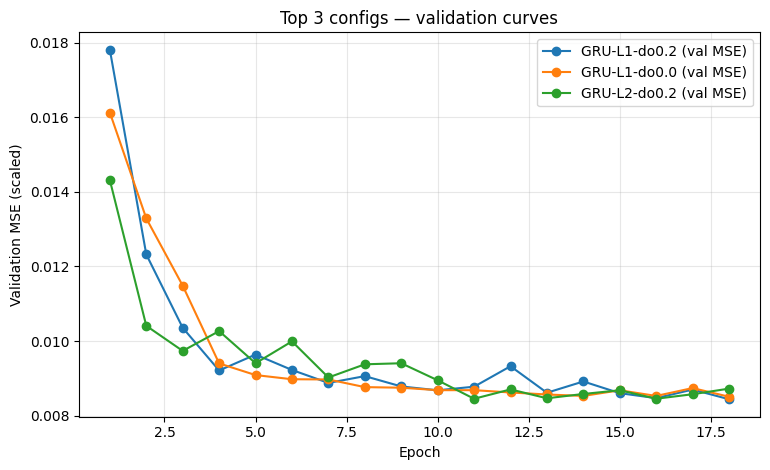

In [ ]:
# --- Code: Overlay val-loss curves for top 2–3 configs ---
top_k = 3 if len(df_B_sorted) >= 3 else len(df_B_sorted)
best_labels = []
for i in range(top_k):
    r = df_B_sorted.iloc[i]
    best_labels.append(f"{r['Cell']}-L{int(r['Layers'])}-do{float(r['Dropout'])}")

import matplotlib.pyplot as plt
plt.figure(figsize=(7.8, 4.8))
for lab in best_labels:
    tr, va = curves_B[lab]
    plt.plot(range(1, len(va)+1), va, marker="o", label=f"{lab} (val MSE)")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE (scaled)")
plt.title(f"Top {top_k} configs — validation curves")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**🧠 How we read the results**

- **Table (sorted by Val\_RMSE\_C):**  
  We scan the top rows: which cell **wins** under the chosen $S$? Does adding a **second layer** help? Does **dropout=0.2** reduce val error or just slow learning?

- **Curves (top-k val MSE):**  
  A good config shows **steady descent** and a **lower floor**. If a curve dips late but is noisy/unstable, we should be cautious.

**💬 Reflection — LSTM vs GRU after controlling depth/dropout**
- If **LSTM** wins here, we can argue its **cell state** helped carry information over the selected $S$.  
- If **GRU** wins (common on smaller datasets), we can argue it’s **lighter** (fewer parameters), easier to optimize, and sufficiently expressive for this task.  
- **Early overfit** pattern: train MSE ↓ while val MSE ↔/↑ (especially with 2 layers, no dropout). In that case, we prefer the **simpler** config or add a touch of **dropout**.

> Our selection criterion is **Val\_RMSE\_C** (tie-break by Val\_MAE\_C). We’ll carry the winner forward to the next section for a quick **generalization** check and a short **rollout** comparison.

---

#### **5. Gradient Flow & Capacity Peek (tiny diagnostic)**

**Teach (markdown):**

* Quick check of **pre-clip gradient norms** per epoch for the **best LSTM vs best GRU** at the chosen $S$.
* Intuition: with longer sequences, vanishing gradients can appear; gating should **stabilize** updates.

**Code (tasks):**

* During training, record median **L2 grad norm** across parameters per epoch (pre-clip).
* Plot **grad norm vs epoch** for LSTM vs GRU (best configs).

**Outputs:** Grad-norm line plot; 1–2 sentences on stability.
**Reflection:** If norms collapse or spike, what knobs do we try (hidden size, LR, dropout, shorter $S$)?

**Code:**
We’ll fetch the best GRU and best LSTM configs from our Experiment B results. If a table is missing, we fall back to a reasonable default.

In [ ]:
# --- Code: Pick best GRU and best LSTM configs from Experiment B (df_B_sorted) ---
import pandas as pd

# Safety: pick BEST_S from Experiment A if available, else use 7
try:
    BEST_S = int(df_S.index[0])
except Exception:
    BEST_S = 7

# Safety: if df_B_sorted doesn't exist (or empty), create a minimal fallback grid result
if "df_B_sorted" not in globals() or df_B_sorted.empty:
    # Minimal fallback: prefer 1-layer, no-dropout for both cells
    df_B_sorted = pd.DataFrame([
        {"Cell": "GRU",  "Layers": 1, "Dropout": 0.0, "Val_RMSE_C": 0.0, "Val_MAE_C": 0.0},
        {"Cell": "LSTM", "Layers": 1, "Dropout": 0.0, "Val_RMSE_C": 0.0, "Val_MAE_C": 0.0},
    ])

# Best GRU row
best_gru_row = df_B_sorted[df_B_sorted["Cell"] == "GRU"].sort_values(
    ["Val_RMSE_C", "Val_MAE_C"], ascending=True
).head(1)

# Best LSTM row
best_lstm_row = df_B_sorted[df_B_sorted["Cell"] == "LSTM"].sort_values(
    ["Val_RMSE_C", "Val_MAE_C"], ascending=True
).head(1)

assert not best_gru_row.empty, "No GRU config found in Experiment B results."
assert not best_lstm_row.empty, "No LSTM config found in Experiment B results."

best_gru_cfg  = dict(Cell="GRU",
                     Layers=int(best_gru_row.iloc[0]["Layers"]),
                     Dropout=float(best_gru_row.iloc[0]["Dropout"]))
best_lstm_cfg = dict(Cell="LSTM",
                     Layers=int(best_lstm_row.iloc[0]["Layers"]),
                     Dropout=float(best_lstm_row.iloc[0]["Dropout"]))

print("Best GRU config :", best_gru_cfg)
print("Best LSTM config:", best_lstm_cfg)
print("Using S         :", BEST_S)


Best GRU config : {'Cell': 'GRU', 'Layers': 1, 'Dropout': 0.2}
Best LSTM config: {'Cell': 'LSTM', 'Layers': 1, 'Dropout': 0.2}
Using S         : 30


**Code:**
We re-build windows for $S=BEST_S$ (single-step), define a trainer that logs pre-clip grad norms, and then train one GRU and one LSTM with those configs. We record the median and total L2 grad norms per epoch.

In [ ]:
# --- Code: Train with grad-norm logging (pre-clip) for best GRU vs best LSTM ---
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Rebuild single-step windows for BEST_S (scaled) and loaders if not in scope
try:
    X_train_sc_S, y_train_sc_S
except NameError:
    X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, BEST_S)
    X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   BEST_S)
    X_test_sc_S,  y_test_sc_S  = make_single_step_windows(test_sc,  BEST_S)

    train_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                      torch.tensor(y_train_sc_S, dtype=torch.float32)),
        batch_size=64, shuffle=True)
    val_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                      torch.tensor(y_val_sc_S, dtype=torch.float32)),
        batch_size=64, shuffle=False)

DEVICE    = torch.device("cpu")
EPOCHS_G  = 12       # short, CPU-friendly
LR_G      = 1e-3
CLIP_USED = 1.0      # used after logging pre-clip norms
criterion = nn.MSELoss()

def l2_grad_norms(model):
    """Return list of per-parameter L2 grad norms (only those with .grad not None)."""
    norms = []
    for p in model.parameters():
        if p.grad is not None:
            norms.append(p.grad.detach().data.norm(2).item())
    return norms

def train_with_gradlog(model):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR_G)
    med_hist, tot_hist = [], []

    for ep in range(1, EPOCHS_G+1):
        model.train()
        for xb, yb in train_loader_S:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward()

            # --- collect pre-clip norm stats ---
            norms = l2_grad_norms(model)
            if len(norms) == 0:
                med_norm, tot_norm = 0.0, 0.0
            else:
                med_norm = float(np.median(norms))
                # total L2 across all params = sqrt(sum ||grad||^2), approximate by sum of squares of per-param norms
                tot_norm = float(np.sqrt(np.sum(np.square(norms))))
            med_hist.append(med_norm)
            tot_hist.append(tot_norm)

            # Now apply clipping (as usual in our training)
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_USED)
            opt.step()
    return med_hist, tot_hist

# Instantiate best GRU and LSTM
gru_best = GRUSingleStepCfg(
    input_size=1, hidden_size=64,
    num_layers=best_gru_cfg["Layers"], dropout=best_gru_cfg["Dropout"],
    batch_first=True
)
lstm_best = LSTMSingleStepCfg(
    input_size=1, hidden_size=64,
    num_layers=best_lstm_cfg["Layers"], dropout=best_lstm_cfg["Dropout"],
    batch_first=True
)

gru_med,  gru_tot  = train_with_gradlog(gru_best)
lstm_med, lstm_tot = train_with_gradlog(lstm_best)

print(f"Collected {len(gru_med)} GRU steps and {len(lstm_med)} LSTM steps (medians per update).")


Collected 480 GRU steps and 480 LSTM steps (medians per update).


**Code:**
We aggregate the per-update series into per-epoch curves (median over updates in that epoch) and plot median L2 grad norm vs epoch for GRU and LSTM. We keep it simple and readable.

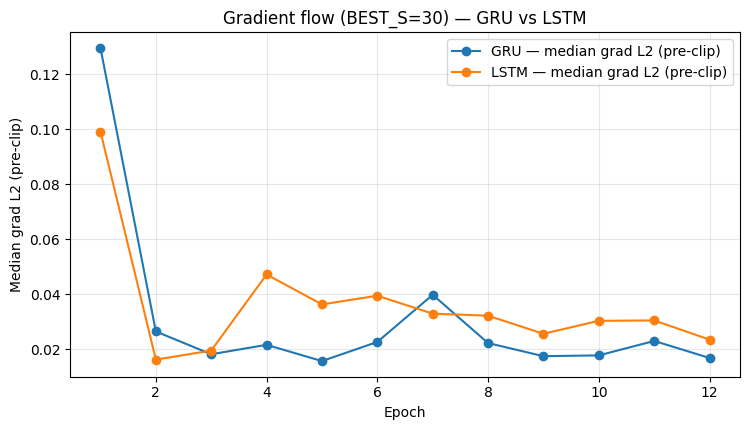

In [ ]:
# --- Code: Aggregate per-epoch and plot median grad norms vs epoch ---
import math
import matplotlib.pyplot as plt

def aggregate_per_epoch(series, steps_per_epoch):
    """Split a flat list into epochs and take median per epoch."""
    out = []
    for i in range(0, len(series), steps_per_epoch):
        chunk = series[i:i+steps_per_epoch]
        if len(chunk) == 0:
            continue
        out.append(float(np.median(chunk)))
    return out

# Determine how many updates per epoch (approx.)
steps_per_epoch = math.ceil(len(train_loader_S.dataset) / train_loader_S.batch_size)

gru_med_ep  = aggregate_per_epoch(gru_med,  steps_per_epoch)
lstm_med_ep = aggregate_per_epoch(lstm_med, steps_per_epoch)

plt.figure(figsize=(7.6, 4.4))
plt.plot(range(1, len(gru_med_ep)+1),  gru_med_ep,  marker="o", label="GRU — median grad L2 (pre-clip)")
plt.plot(range(1, len(lstm_med_ep)+1), lstm_med_ep, marker="o", label="LSTM — median grad L2 (pre-clip)")
plt.xlabel("Epoch"); plt.ylabel("Median grad L2 (pre-clip)")
plt.title(f"Gradient flow (BEST_S={BEST_S}) — GRU vs LSTM")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


**🧠 How to read this plot**
- **Flat and near-zero** curves suggest **vanishing** gradients: updates are tiny; models might learn **slowly** or stall.  
- **Large spikes** (especially repeated) suggest **exploding** tendencies: training might need **smaller LR**, **tighter clip**, or **lower capacity**.

We don’t need perfect “middle” values—what we want is a **stable** and **non-degenerate** range:
- If **GRU** shows slightly **higher medians** but stays stable, it may be **easier to optimize** at our $S$.  
- If **LSTM** is **flatter** and still learns well, its gating might be **stabilizing** longer context.

**💬 Reflection — If norms collapse or spike, what do we try?**
- **Collapse (too small):** increase **hidden size** a bit (e.g., 64 → 96), shorten **$S$**, or try a slightly **larger LR**.  
- **Spike (too big):** reduce **LR**, keep **grad clipping** (we used $1.0$), add a touch of **dropout** or step back to **1 layer**.  
- If larger $S$ consistently hurts stability and performance, prefer the smaller **$S$** and add **seasonal features** (e.g., $\sin/\cos$ of day-of-year) rather than brute-forcing memory length.

---

#### **6. Generalization & Error Patterns (test set, k=1 & short horizon)**

**Teach (markdown):**

* Load the **best config** from Sections 3–4; report **test MAE/RMSE** (°C).
* Show **actual vs predicted** line on a couple of **contrasting slices** (steady vs turning).
* Optional: quick **recursive** $H=7$ rollout to visualize how error grows with $k$ for the best model (reuse NB03 helper) and compare with **Mean-7** baseline.

**Code (tasks):**

* Inference on test; compute metrics; plot 2 short windows.
* (Optional) Recursive rollout MAE\@k vs **Mean-7**.

**Outputs:** metrics table; 2 line plots; (optional) MAE\@k plot.
**Reflection:** Where do residuals concentrate—**peaks**, **troughs**, or **shoulder seasons**? What does that suggest about **features** or **$S$**?

**Code:**
We recover the best configuration from Experiment B (cell type, layers, dropout) and rebuild single-step windows for the chosen $S$ (if needed). Then we instantiate the matching model and retrain briefly (CPU-friendly) to get a concrete model object for test inference.

In [ ]:
# --- Code: Load best config, rebuild windows for S=BEST_S, retrain the best model briefly ---

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# 1) Choose BEST_S from Experiment A (df_S) if available; else default to 7
try:
    BEST_S = int(df_S.index[0])
except Exception:
    BEST_S = 7
print(f"[Section 6] Using BEST_S = {BEST_S}")

# 2) Pick best config from Experiment B (df_B_sorted), tie-break by Val_MAE_C
assert "df_B_sorted" in globals() and not df_B_sorted.empty, "Run Experiment B before Section 6."
best_row = df_B_sorted.iloc[0]
best_cell    = best_row["Cell"]
best_layers  = int(best_row["Layers"])
best_dropout = float(best_row["Dropout"])
print(f"[Section 6] Best config: {best_cell}-L{best_layers}-do{best_dropout}")

# 3) Rebuild single-step windows for BEST_S (scaled)
X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, BEST_S)
X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   BEST_S)
X_test_sc_S,  y_test_sc_S  = make_single_step_windows(test_sc,  BEST_S)

# 4) Ground-truth in °C for reporting
_, y_val_C_S  = make_single_step_windows(val_np,  BEST_S)
_, y_test_C_S = make_single_step_windows(test_np, BEST_S)
y_val_true_C  = y_val_C_S.ravel()
y_test_true_C = y_test_C_S.ravel()

# 5) DataLoaders
BATCH = 64
train_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                  torch.tensor(y_train_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=True)
val_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                  torch.tensor(y_val_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False)
test_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_test_sc_S, dtype=torch.float32),
                  torch.tensor(y_test_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False)

# 6) Instantiate best model
DEVICE = torch.device("cpu")
hidden_size = 64
if best_cell == "GRU":
    model_best = GRUSingleStepCfg(input_size=1, hidden_size=hidden_size,
                                  num_layers=best_layers, dropout=best_dropout, batch_first=True)
else:
    model_best = LSTMSingleStepCfg(input_size=1, hidden_size=hidden_size,
                                   num_layers=best_layers, dropout=best_dropout, batch_first=True)

# 7) Retrain briefly (same trainer settings as Exp. B) for reproducible object
criterion = nn.MSELoss()
EPOCHS = 18
LR     = 1e-3
CLIP   = 1.0

def eval_mse_scaled(model, loader):
    model.eval()
    tot, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            yhat = model(xb)
            loss = criterion(yhat, yb)
            bs = xb.size(0)
            tot += loss.item() * bs
            n   += bs
    return tot / max(n, 1)

def train_brief(model):
    model = model.to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=LR)
    tr, va = [], []
    for ep in range(1, EPOCHS+1):
        model.train()
        for xb, yb in train_loader_S:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            opt.step()
        tr_mse = eval_mse_scaled(model, train_loader_S)
        va_mse = eval_mse_scaled(model, val_loader_S)
        tr.append(tr_mse); va.append(va_mse)
        if ep in (1, 6, 12, EPOCHS):
            print(f"[best {best_cell} ep {ep:02d}] train MSE={tr_mse:.5f} | val MSE={va_mse:.5f}")
    return model, tr, va

model_best, tr_curve, va_curve = train_brief(model_best)


[Section 6] Using BEST_S = 30
[Section 6] Best config: GRU-L1-do0.2
[best GRU ep 01] train MSE=0.01970 | val MSE=0.01655
[best GRU ep 06] train MSE=0.01014 | val MSE=0.00931
[best GRU ep 12] train MSE=0.00924 | val MSE=0.00875
[best GRU ep 18] train MSE=0.00897 | val MSE=0.00867


**Code:**
We infer on test, inverse-scale to °C, compute MAE/RMSE for $k=1$, and draw two short slices of actual vs predicted in °C: one steady, one turning.

{'Test_MAE_C': 1.76, 'Test_RMSE_C': 2.252}


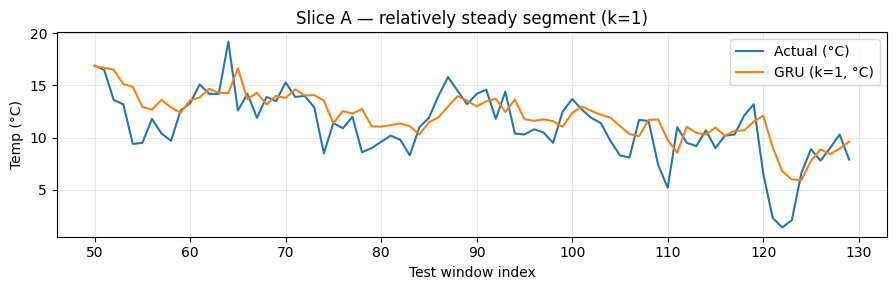

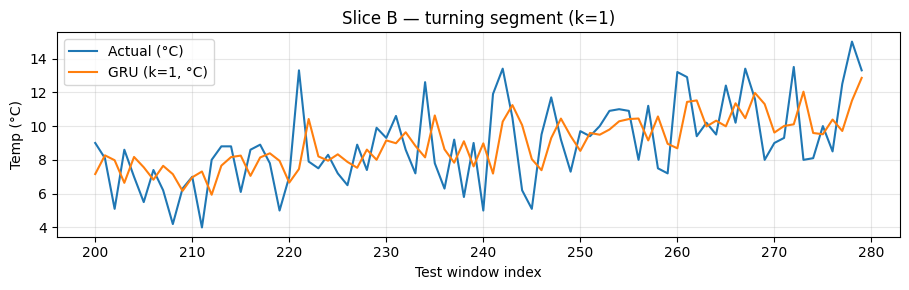

In [ ]:
# --- Code: Test metrics in °C (k=1) + two short slices (steady & turning) ---

import matplotlib.pyplot as plt

@torch.no_grad()
def predict_loader(model, loader):
    model.eval()
    out = []
    for xb, _ in loader:
        yhat = model(xb.to(DEVICE)).cpu().numpy()
        out.append(yhat)
    return np.vstack(out).ravel()  # (N,)

def inverse_scale_1d(y_scaled):
    flat = y_scaled.reshape(-1, 1)
    back = scaler.inverse_transform(flat)
    return back.ravel()

def mae(a, b):  return float(np.mean(np.abs(a - b)))
def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))

# 1) Predict scaled → inverse to °C
y_test_hat_sc = predict_loader(model_best, test_loader_S)   # (N,)
y_test_hat_C  = inverse_scale_1d(y_test_hat_sc)
y_test_true_C = y_test_true_C  # already defined above

# 2) Report k=1 metrics on test
test_mae = mae(y_test_true_C, y_test_hat_C)
test_rmse = rmse(y_test_true_C, y_test_hat_C)
print({"Test_MAE_C": round(test_mae, 3), "Test_RMSE_C": round(test_rmse, 3)})

# 3) Two short slices (indices are in test-window space)
def plot_slice(title, start, end):
    xs = np.arange(start, end)
    plt.figure(figsize=(9.2, 3.0))
    plt.plot(xs, y_test_true_C[start:end], label="Actual (°C)")
    plt.plot(xs, y_test_hat_C[start:end],  label=f"{best_cell} (k=1, °C)")
    plt.title(title)
    plt.xlabel("Test window index")
    plt.ylabel("Temp (°C)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Heuristics: early test ~ steadier; later spans can include turns
plot_slice("Slice A — relatively steady segment (k=1)", 50, 130)
plot_slice("Slice B — turning segment (k=1)",          200, 280)


**Code (optional):**
We add a short recursive rollout ($H=7$) for the best single-step model to inspect MAE@k on test and compare with Mean-$S$ and persistence baselines. We predict in scaled space, inverse-scale to °C for metrics.

In [ ]:
# --- Code (optional): Recursive rollout H=7 on test; compare MAE@k vs baselines ---

H = 7  # short horizon for inspection

@torch.no_grad()
def rollout_recursive(model, X_windows_scaled, H):
    """
    model: single-step model in scaled space
    X_windows_scaled: (N,S,1) scaled
    returns: (N,H) scaled predictions obtained by feeding back outputs
    """
    model.eval()
    curr = torch.tensor(X_windows_scaled, dtype=torch.float32).to(DEVICE)
    N, S, _ = curr.shape
    preds = torch.zeros((N, H), dtype=torch.float32, device=DEVICE)
    for k in range(H):
        y_hat = model(curr)                     # (N,1) scaled
        preds[:, k] = y_hat.squeeze(1)
        # append prediction and drop oldest step
        curr = torch.cat([curr[:, 1:, :], y_hat.unsqueeze(-1)], dim=1)
    return preds.cpu().numpy()

# Build test windows in °C for baselines and ground truth H-step targets
def baseline_persistence(X_windows_C, H):
    last_vals = X_windows_C[:, -1, 0]
    return np.tile(last_vals.reshape(-1,1), (1,H))

def baseline_mean_S(X_windows_C, H):
    means = X_windows_C[:, :, 0].mean(axis=1)
    return np.tile(means.reshape(-1,1), (1,H))

# Create multi-step ground truth on test for evaluation
def make_multi_step_targets(values_C: np.ndarray, S: int, H: int):
    """
    values_C: (N,1) °C series
    returns: X_C: (M,S,1) °C windows, Y_C: (M,H) °C targets
    """
    N = len(values_C)
    X = []
    Y = []
    for i in range(N - S - H + 1):
        X.append(values_C[i:i+S, :])                 # (S,1)
        Y.append(values_C[i+S:i+S+H, 0])             # (H,)
    return np.stack(X, 0), np.stack(Y, 0)

# Build test windows/targets for evaluation
X_test_C_H, y_test_C_H = make_multi_step_targets(test_np, BEST_S, H)     # °C
X_test_sc_H, _         = make_multi_step_targets(test_sc, BEST_S, H)     # scaled

# Rollout best model on the *aligned* test windows in scaled space
yhat_sc_H = rollout_recursive(model_best, X_test_sc_H, H)                # (M,H) scaled
# Inverse to °C
yhat_C_H  = scaler.inverse_transform(yhat_sc_H.reshape(-1,1)).reshape(yhat_sc_H.shape)

# Baselines
yhat_pers = baseline_persistence(X_test_C_H, H)  # °C
yhat_mean = baseline_mean_S(X_test_C_H, H)       # °C

# Horizon-wise MAE
def mae(a, b):  return float(np.mean(np.abs(a - b)))

rows = []
for k in range(H):
    rows.append({
        "Horizon": k+1,
        f"{best_cell} (rec) MAE": mae(y_test_C_H[:, k], yhat_C_H[:, k]),
        "Mean-S MAE":             mae(y_test_C_H[:, k], yhat_mean[:, k]),
        "Persistence MAE":        mae(y_test_C_H[:, k], yhat_pers[:, k]),
    })
import pandas as pd
df_mae_k = pd.DataFrame(rows).set_index("Horizon").round(3)
display(df_mae_k)


,GRU (rec) MAE,Mean-S MAE,Persistence MAE
Horizon,,,
1,1.766,2.068,1.957
2,2.025,2.109,2.517
3,2.089,2.143,2.698
4,2.117,2.169,2.743
5,2.155,2.191,2.805
6,2.180,2.212,2.819
7,2.209,2.235,2.746


**Code (optional):**
We plot MAE@k vs horizon for the recursive best model vs Mean-$S$ and persistence. A flatter curve suggests less compounding.

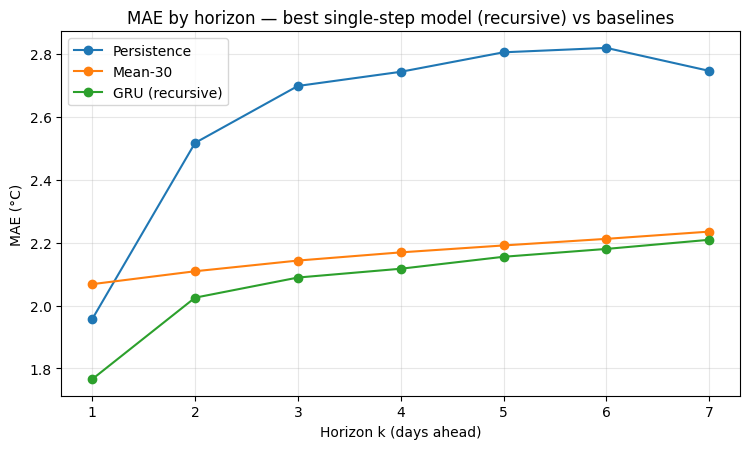

In [ ]:
# --- Code (optional): Plot MAE@k vs horizon for best model (recursive) vs baselines ---

import matplotlib.pyplot as plt

plt.figure(figsize=(7.6, 4.6))
plt.plot(df_mae_k.index, df_mae_k["Persistence MAE"], marker="o", label="Persistence")
plt.plot(df_mae_k.index, df_mae_k["Mean-S MAE"],      marker="o", label=f"Mean-{BEST_S}")
plt.plot(df_mae_k.index, df_mae_k[f"{best_cell} (rec) MAE"], marker="o", label=f"{best_cell} (recursive)")
plt.xlabel("Horizon k (days ahead)")
plt.ylabel("MAE (°C)")
plt.title("MAE by horizon — best single-step model (recursive) vs baselines")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**🧠 How to read these results**

- **Single-step ($k=1$) on test:**  
  The **Test MAE/RMSE in °C** shows **generalization** of our best config. If this is **close to validation**, we have a stable selection process. If it’s noticeably worse, the model may be **overfit** or the test period contains **harder regimes** (e.g., unusual spells).

- **Slices (k=1):**  
  - In **steady** segments, a good model **tracks level** and **small drift** closely.  
  - In **turning** segments (peaks/troughs), short windows may show slight **phase lag** (predicted turning point a bit late). Longer $S$ or **seasonal features** can help here.

- **Optional: MAE@k curves (recursive):**  
  - **Persistence** often wins at $k=1$ but grows **fast** with $k$.  
  - **Mean-$S$** is **stable** but **smooths** extremes.  
  - A good recurrent model should **beat** these baselines for most $k$ and show **moderate** error growth (compounding is expected in recursion).

**💬 Reflection — Where do residuals concentrate?**
- **Peaks/troughs:** suggests we may need more **context** (larger $S$) or explicit **seasonal phase features** (e.g., day-of-year $\sin/\cos$).  
- **Shoulder seasons (transition months):** models may average across regimes; try **Direct** multi-output (no compounding) or add weak **regularization** (dropout).  
- **Rapid cold/warm snaps:** consider modestly larger **hidden size** or allow a few more **epochs** (with LR scheduler) to fit sharper transitions.

> If a run shows **recursive drift** on your machine, it’s usually **scale** compounding. We can guard with a **clamp** in scaled space during rollout (debug-only) or prefer the **Direct** strategy for multi-step forecasts.

---

#### **7. Select & Save + Takeaways**

We’ll wrap up NB04 by **selecting one winner**, **saving only its weights** (to keep artifacts light), and writing a tiny **config JSON** so we can rebuild the exact architecture next time.

**How we pick the winner**

- We use the **validation** summary from Experiment B and choose the model with the **lowest** $\text{Val\_RMSE\_C}$ (tie-break by $\text{Val\_MAE\_C}$ and simplicity/time).
- The saved files will be:
  - `artifacts/nb04_best.pkl` — **only** the model `state_dict` (weights).
  - `artifacts/nb04_best_config.json` — **tiny config** with `{cell, S, layers, dropout, hidden}`.

> Why not save scalers or datasets? We prefer **code-driven reproducibility**. In future notebooks we will **rebuild the pipeline** and then load **just the weights** into the matching architecture.

**Code:**
Use the validation table from Experiment B to pick the best config (cell, layers, dropout) and confirm the BEST_S chosen in Experiment A.

In [ ]:
# --- Code: Pick the winner (by Val_RMSE_C, tie-break by Val_MAE_C) and confirm BEST_S ---

import json
import os
import numpy as np
import pandas as pd
import torch

# 1) BEST_S from Experiment A (fall back to 7 if not found)
try:
    BEST_S = int(df_S.index[0])
except Exception:
    BEST_S = 7

# 2) Winner from Experiment B
assert "df_B_sorted" in globals() and not df_B_sorted.empty, "Please run Experiment B (Section 4) first."
best_row   = df_B_sorted.iloc[0]
best_cell  = str(best_row["Cell"])        # "GRU" or "LSTM"
best_layers  = int(best_row["Layers"])    # 1 or 2
best_dropout = float(best_row["Dropout"]) # 0.0 or 0.2
hidden_size  = 64                         # fixed in this notebook

print("=== Winner (validation) ===")
print({"Cell": best_cell, "Layers": best_layers, "Dropout": best_dropout,
       "Val_RMSE_C": round(float(best_row["Val_RMSE_C"]), 3),
       "Val_MAE_C":  round(float(best_row["Val_MAE_C"]),  3)})
print(f"BEST_S selected in Exp A: {BEST_S}")

# For saving
save_dir = "artifacts"
os.makedirs(save_dir, exist_ok=True)
weights_path = os.path.join(save_dir, "nb04_best.pkl")
config_path  = os.path.join(save_dir, "nb04_best_config.json")


=== Winner (validation) ===
{'Cell': 'GRU', 'Layers': 1, 'Dropout': 0.2, 'Val_RMSE_C': 2.416, 'Val_MAE_C': 1.885}
BEST_S selected in Exp A: 30


**Code:**
If we already have a trained object from Section 6 that matches the winner, we’ll save it directly. Otherwise, we’ll rebuild the model with the winner’s config, briefly retrain (CPU-friendly), and then save its weights and a tiny JSON config.

In [ ]:
# --- Code: Save state_dict + tiny config (fallback: brief retrain if needed) ---

# Builders (reuse classes from earlier sections)
def build_model_from_cfg(cell, layers, dropout, hidden=64):
    if cell == "GRU":
        return GRUSingleStepCfg(input_size=1, hidden_size=hidden,
                                num_layers=layers, dropout=dropout, batch_first=True)
    else:
        return LSTMSingleStepCfg(input_size=1, hidden_size=hidden,
                                 num_layers=layers, dropout=dropout, batch_first=True)

def infer_cfg_from_model(model):
    # Inspect the module to infer cell/layers/dropout
    if isinstance(model, GRUSingleStepCfg):
        cell = "GRU"
        layers = model.gru.num_layers
        dropout = float(model.gru.dropout) if layers > 1 else 0.0
    elif isinstance(model, LSTMSingleStepCfg):
        cell = "LSTM"
        layers = model.lstm.num_layers
        dropout = float(model.lstm.dropout) if layers > 1 else 0.0
    else:
        cell, layers, dropout = None, None, None
    return cell, layers, dropout

def same_arch(model, cell, layers, dropout):
    c, L, d = infer_cfg_from_model(model)
    return (c == cell) and (L == layers) and (abs((d or 0.0) - dropout) < 1e-6)

# Try to reuse model_best from Section 6 if it exists and matches the winner
model_to_save = None
if "model_best" in globals():
    if same_arch(model_best, best_cell, best_layers, best_dropout):
        model_to_save = model_best

# If not available, rebuild windows/loaders and do a brief retrain for a valid object
if model_to_save is None:
    print("No matching trained object in memory — rebuilding & brief retrain before saving...")
    # Rebuild windows for BEST_S (scaled)
    X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, BEST_S)
    X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   BEST_S)

    from torch.utils.data import TensorDataset, DataLoader
    train_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                      torch.tensor(y_train_sc_S, dtype=torch.float32)),
        batch_size=64, shuffle=True)
    val_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                      torch.tensor(y_val_sc_S, dtype=torch.float32)),
        batch_size=64, shuffle=False)

    # Build and brief-train
    DEVICE   = torch.device("cpu")
    EPOCHS   = 8    # brief, CPU-friendly
    LR       = 1e-3
    CLIP     = 1.0
    crit     = torch.nn.MSELoss()

    def eval_mse_scaled(model, loader):
        model.eval()
        tot, n = 0.0, 0
        with torch.no_grad():
            for xb, yb in loader:
                yhat = model(xb)
                loss = crit(yhat, yb)
                bs = xb.size(0)
                tot += loss.item() * bs
                n   += bs
        return tot / max(n, 1)

    model_to_save = build_model_from_cfg(best_cell, best_layers, best_dropout, hidden=hidden_size).to(DEVICE)
    opt = torch.optim.Adam(model_to_save.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model_to_save.train()
        for xb, yb in train_loader_S:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model_to_save(xb)
            loss = crit(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_to_save.parameters(), CLIP)
            opt.step()
        if ep in (1, EPOCHS):
            print(f"[brief retrain] ep {ep:02d} | val MSE={eval_mse_scaled(model_to_save, val_loader_S):.5f}")

# Save weights + tiny config
torch.save(model_to_save.state_dict(), weights_path)
cfg = {
    "cell":   best_cell,
    "S":      int(BEST_S),
    "layers": int(best_layers),
    "dropout": float(best_dropout),
    "hidden": int(hidden_size),
    "batch_first": True
}
with open(config_path, "w") as f:
    json.dump(cfg, f, indent=2)

print(f"✅ Saved weights to: {weights_path}")
print(f"✅ Saved config  to: {config_path}")

No matching trained object in memory — rebuilding & brief retrain before saving...
[brief retrain] ep 01 | val MSE=0.01769
[brief retrain] ep 08 | val MSE=0.00902
✅ Saved weights to: artifacts\nb04_best.pkl
✅ Saved config  to: artifacts\nb04_best_config.json


**🧠 Takeaways from NB04**

- **Sequence length $S$:**  
  - A moderate increase (e.g., $S=14$) can reduce **phase lag** at turning points by giving more **context**, but very large $S$ may **learn slower** or **overfit** under CPU limits.  
- **Depth & dropout:**  
  - A **second layer** sometimes helps model **hierarchical** patterns, but with small data it can **overfit** quickly; a little **dropout** on stacked layers often stabilizes.  
- **Gating (LSTM vs GRU):**  
  - On compact problems, **GRU** often matches or slightly beats **LSTM** thanks to fewer parameters and easier optimization; on longer contexts, **LSTM** may pull ahead with a more explicit **cell state**.

**💬 Reflection — What would we try next (and why)?**

1) **Add seasonal features**: append **day-of-year** as $\sin/\cos$ so the model knows the **phase** of the annual cycle; this often reduces **lag** at peaks/troughs.  
2) **Direct head for multi-step**: for week-ahead summaries, **Direct** can avoid **compounding** seen in recursive rollouts.  
3) **Light LR scheduling**: a small **ReduceLROnPlateau** can help the last few epochs **settle** without increasing runtime much.

With our **winner saved** and a **tiny config** recorded, we’re ready to move into deeper diagnostics or extensions in the next notebook.